In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

import importlib
importlib.reload(bt)

<module 'bt_tools' from '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/bt_tools.py'>

In [2]:
data_pbe0 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_pbe0 = data_pbe0.loc[(data_pbe0['Z1'] <= 9) & (data_pbe0['Z2'] <= 9)].to_dict('list')
data_pbe0['unit'] = 630

data_W4_17 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/W4-17.csv').to_dict('list')
data_G2 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/G2.csv').to_dict('list')
data_W4_17['unit'] = 1
data_G2['unit'] = 1

In [3]:
# do linear fits
b_pbe0 = bt.BDE_clean.fromdict(data_pbe0)
b_W4_17 = bt.BDE_clean.fromdict(data_W4_17)
b_G2 = bt.BDE_clean.fromdict(data_G2)
for b in [b_pbe0, b_W4_17, b_G2]:
    b.linear_fit()
    print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))

MAE = 0.5134766712980074
MAE = 0.28545588235294445
MAE = 9.829174511348053e-14


In [4]:
# do non-linear fits
def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = a - b*Z1*Z2 - c*(Z1**(7/3) + Z2**(7/3)) # (-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    return(ebfe)

b_pbe0_nl = bt.BDE_clean.fromdict(data_pbe0)
b_W4_17_nl = bt.BDE_clean.fromdict(data_W4_17)
b_G2_nl = bt.BDE_clean.fromdict(data_G2)
for b in [b_pbe0_nl, b_W4_17_nl, b_G2_nl]:
    b.fit(non_linear_model)
    print('non-linear MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))

non-linear MAE = 0.9976125874934105
non-linear MAE = 0.9241641912200009
non-linear MAE = 0.38992847387965784


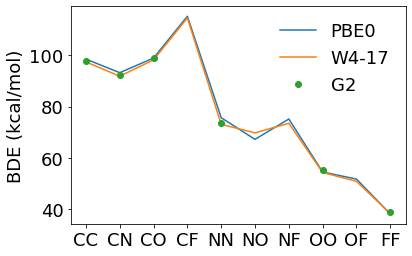

In [5]:
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,1)

ax.plot(data_pbe0['smiles'], b_pbe0.bde, label = 'PBE0')
ax.plot(data_W4_17['smiles'], b_W4_17.bde, label = 'W4-17')
ax.plot(data_G2['smiles'], b_G2.bde, 'o', label = 'G2')

ax.set_ylabel('BDE (kcal/mol)')
ax.legend(frameon=False)

Error PBE: linear model 0.51kcal/mol, non-linear model 1.00 kcal/mol

Error W4-17: linear model 0.29 kcal/mol, non-linear model 0.92 kcal/mol

Error G2: linear model 9.83e-14 kcal/mol, non-linear model 0.39 kcal/mol

Error PBE0 vs W4-17: 1.18 kcal/mol

The error of the fit with respect to the training data is smaller than the error between DFT and CCSD(T).

In [6]:
print('MAE pbe0 with respect to W4-17 = ' + str(np.abs(b_W4_17.bde-b_pbe0.bde).mean()))

MAE pbe0 with respect to W4-17 = 1.1771049798165698


In [7]:
b_W4_17.bde

array([ 97.41,  91.85,  98.18, 114.56,  73.08,  69.74,  73.49,  54.29,
        50.85,  38.25])

In [8]:
b_G2.bde

array([97.7328, 92.3352, 98.9592, 73.6296, 55.1376, 38.9544])

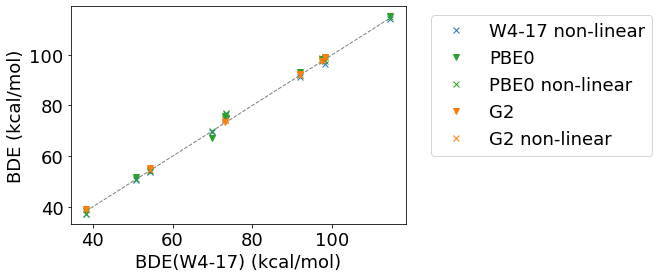

In [10]:
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(1,1)

ref = np.linspace(np.amin(b_W4_17.bde), np.amax(b_W4_17.bde), 3)

ax.plot(ref, ref, '--', color = 'tab:gray', linewidth= 1)

# ax.plot(b_W4_17.bde, b_W4_17.bde_fitted, 'o', color = 'tab:blue', label = 'W4-17 linear')
ax.plot(b_W4_17.bde, b_W4_17_nl.bde_fitted, 'x', color = 'tab:blue', label = 'W4-17 non-linear')

ax.plot(b_W4_17.bde, b_pbe0.bde, 'v', color = 'tab:green', label = 'PBE0')
# ax.plot(b_W4_17.bde, b_pbe0.bde_fitted, 'o', color = 'tab:green', label = 'PBE0 linear')
ax.plot(b_W4_17.bde, b_pbe0_nl.bde_fitted, 'x', color = 'tab:green', label = 'PBE0 non-linear')


indices = []
for s in data_G2['smiles']:
    indices.append(data_W4_17['smiles'].index(s))

ax.plot(b_W4_17.bde[indices], b_G2.bde, 'v', color = 'tab:orange', label = 'G2')
# ax.plot(b_W4_17.bde[indices], b_G2.bde_fitted, 'o', color = 'tab:orange', label = 'G2 linear')
ax.plot(b_W4_17.bde[indices], b_G2_nl.bde_fitted, 'x', color = 'tab:orange', label = 'G2 non-linear')

ax.set_ylabel('BDE (kcal/mol)')

ax.set_xlabel('BDE(W4-17) (kcal/mol)')

ax.legend(bbox_to_anchor=(1.05, 1.0))

In [11]:
data_pbe0 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_pbe0 = data_pbe0.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_pbe0['unit'] = 630

data_W4_17 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/W4-17.csv').to_dict('list')
data_G2 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/G2.csv').to_dict('list')
data_W4_17['unit'] = 1
data_G2['unit'] = 1

NameError: name 'data' is not defined

In [12]:
# pick smiles to leave out
lo = ['CC', 'OF']

lo_ind = []
for s in lo:
    lo_ind.append(data['smiles'].index(s))
    

# split in training and test
for k in data.keys():
    if k not 'unit':
        data[k]

SyntaxError: invalid syntax (<ipython-input-12-8716e8b0783f>, line 11)

In [ ]:
np.arange(len(b_W4_17.bfe))

In [ ]:
xdata
ebfe
nbfe
bfe
bde

# split_var = [self.xdata, self.ebfe, self.nbfe, self.bfe, self.bde]
split_var = [b_W4_17.xdata, b_W4_17.ebfe, b_W4_17.nbfe, b_W4_17.bfe, b_W4_17.bde]


def train(self, tr_ind, model, p0 = None):
    if p0 is not None:
        self.params_tr = curve_fit(model, self.xdata[tr_ind], self.ebfe[tr_ind], p0, maxfev=100000)
    else:
        self.params_tr = curve_fit(model, self.xdata[tr_ind], self.ebfe[tr_ind])

    self.ebfe_fitted_tr = model(self.xdata[tr_ind], *self.params_tr[0])
    self.bde_fitted_tr = -(self.ebfe_fitted_tr + self.nbfe[tr_ind])
    self.mae_tr = np.abs(self.bde_fitted_tr-self.bde[tr_ind]).mean()
    
def predict(self, test_ind, model):
    self.ebfe_fitted_test = model(self.xdata[test_ind], *self.params_tr[0])
    self.bde_fitted_test = -(self.ebfe_fitted_test + self.nbfe[test_ind])
    self.mae_test = np.abs(self.bde_fitted_test-self.bde[test_ind]).mean()

[0 1 2 3 4 8 9] [5 6 7]


/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


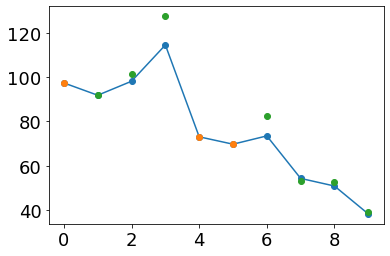

In [13]:
# tr_ind = np.array([0, 1, 2, 3, 5, 6, 7, 9])
# test_ind = np.array([4, 8])

tr_size = 3
all_ind = np.arange(10)
np.random.shuffle(all_ind)
tr_ind, test_ind = np.sort(all_ind[:tr_size]), np.sort(all_ind[tr_size:])

b_W4_17.train(tr_ind, non_linear_model)
b_W4_17.predict(test_ind, non_linear_model)

plt.plot(b_W4_17.bde, '-o')
# plt.plot(b_W4_17.bde_fitted, '-o')

plt.plot(tr_ind, b_W4_17.bde_fitted_tr, 'o')
plt.plot(test_ind, b_W4_17.bde_fitted_test, 'o')

In [14]:
def get_cv(num_cv, tr_size):
    mae_tr = []
    mae_test = []
    for i in range(num_cv):
        all_ind = np.arange(10)
        np.random.shuffle(all_ind)
        tr_ind, test_ind = np.sort(all_ind[:tr_size]), np.sort(all_ind[tr_size:])

        b_W4_17.train(tr_ind, non_linear_model)
        b_W4_17.predict(test_ind, non_linear_model)

        mae_tr.append(b_W4_17.mae_tr)
        mae_test.append(b_W4_17.mae_test)

    return(np.array(mae_tr).mean(), np.array(mae_test).mean(), np.array(mae_tr).std(), np.array(mae_test).std())

mae_tr = []
mae_test = []

std_tr = []
std_test = []

for tr_size in [3, 4, 5, 6, 7, 8, 9, 10]:
    tr, test, trs, tests = get_cv(10, tr_size)
    mae_tr.append(tr)
    mae_test.append(test)
    
    std_tr.append(trs)
    std_test.append(tests)

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/bt_tools.py:87: RuntimeWarning: Mean of empty slice.
  self.mae_test = np.abs(self.bde_fitted_test-self.bde[test_ind]).mean()
/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
len([3, 4, 5, 6, 7, 8, 9])

7

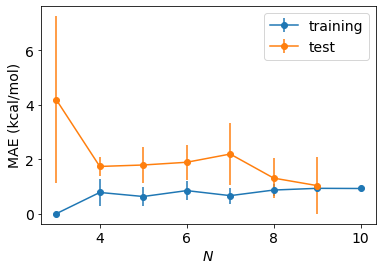

In [95]:
plt.rcParams['font.size'] = 14
plt.errorbar([3, 4, 5, 6, 7, 8, 9, 10], mae_tr,std_tr, x_err = None, marker = 'o', label = 'training')
plt.errorbar([3, 4, 5, 6, 7, 8, 9, 10], mae_test,std_test, x_err = None, marker = 'o', label = 'test')
plt.xlabel(r'$N$')
plt.ylabel('MAE (kcal/mol)')
plt.legend()

In [99]:
b_W4_17_nl.params

(array([-213.25690918,    1.97471679,   -9.38873784]),
 array([[ 8.58573320e+00, -1.41588406e-01,  7.18820651e-01],
        [-1.41588406e-01,  4.92352554e-03, -2.23585489e-02],
        [ 7.18820651e-01, -2.23585489e-02,  1.02876266e-01]]))

# W4-17

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [ ]:
name = []
tae0 = []
with open('/home/sahre/Downloads/W4-17_Ref_TAE0.txt') as f:
    for line in range(5):
        f.readline()
    for line in f:
        if line == '\n':
            break
        out = line.strip('\n').split()
#         print(out)
        name.append(out[0])
        tae0.append(-float(out[1]))
name.append('f')
tae0.append(0)

In [ ]:
w417 = pd.DataFrame({'name':name, 'tae0':tae0})

In [ ]:
frags = ['ch3', 'nh2', 'oh', 'f']
frag_pairs = [['ch3', 'ch3'], ['ch3', 'nh2'], ['ch3', 'oh'], ['ch3', 'f'], ['nh2', 'nh2'], ['nh2', 'oh'], ['nh2', 'f'], ['oh', 'oh'], ['oh', 'f'], ['f', 'f']]

diatomics = ['c2h6', 'ch3nh2', 'methanol', 'ch3f', 'n2h4', 'nh2oh', 'nh2f', 'hooh', 'hof', 'f2']

In [ ]:
w417['tae'] = np.nan
tae = [712.67, 581.91, 512.86, 422.19, 437.94, 359.22, 255.92, 268.39, 157.90, 38.25]
tae_frags = [307.63, 182.43, 107.05, 0]

for d, t in zip(diatomics, tae):
    w417.loc[w417['name'] == d, 'tae'] = -t
    
for d, t in zip(frags, tae_frags):
    w417.loc[w417['name'] == d, 'tae'] = -t

In [ ]:
w417.loc[w417['name'] == 'ch3f']

In [ ]:
def get_tae0(name, dataframe):
    return(dataframe.loc[w417['name'] == name, 'tae'].item())

def get_bfe(dia, frag1, frag2, dataframe):
    tae_dia = get_tae0(dia, dataframe)
    tae_frag1 = get_tae0(frag1, dataframe)
    tae_frag2 = get_tae0(frag2, dataframe)
    bfe = tae_dia - (tae_frag1 + tae_frag2)
    return(bfe)

In [ ]:
# get bond formation energy
bfe = []
for d, frags in zip(diatomics, frag_pairs):
    bfe.append(get_bfe(d, frags[0], frags[1], w417))

In [ ]:
# template data structure for binding class

data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
data_234 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9) | (data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17) | (data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4, data_234]:
    d['unit'] = 630
    
# do linear fits
b2 = bt.BDE_clean.fromdict(data_2)
b3 = bt.BDE_clean.fromdict(data_3)
b4 = bt.BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))

In [ ]:
keys = ['smiles', 'Z1', 'Z2']
data_w4_17 = dict()
for k in keys:
    data_w4_17[k] = data_2[k]
    
data_w4_17['bfe'] = bfe
data_w4_17['unit'] = 1
data_w4_17_save = data_w4_17.copy()

# del data_w4_17_save['unit']
# pd.DataFrame(data_w4_17_save).to_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/W4-17.csv', index=False)

In [ ]:
b2_w4_17 = bt.BDE_clean.fromdict(data_w4_17)

b2_w4_17.linear_fit()

print('linear MAE = ' + str((np.abs(b2_w4_17.bde-b2_w4_17.bde_fitted)).mean()))

# non-linear fits

def non_linear_model(var, alpha, beta, b_prime, a, b):
    Z1, Z2 = var.T
    ebfe = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    return(ebfe)

# do linear fits
b2_w4_17_nl = bt.BDE_clean.fromdict(data_w4_17)

b2_w4_17_nl.fit(non_linear_model)
print('non-linear MAE = ' + str((np.abs(b2_w4_17_nl.bde-b2_w4_17_nl.bde_fitted)).mean()))

In [ ]:
plt.plot(bfe, '-o')
plt.plot(b2.bfe)

In [ ]:
bfe

In [ ]:
(np.abs(bfe - b2.bfe)).mean()

In [ ]:
plt.plot(b2_w4_17.bde)
plt.plot(b2_w4_17.bde_fitted)
plt.plot(b2_w4_17_nl.bde_fitted)

# G2 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [ ]:
def get_tae0(name, dataframe):
    return(dataframe.loc[dataframe['name'] == name, 'tae'].item())

def get_bfe(dia, frag1, frag2, dataframe):
    tae_dia = get_tae0(dia, dataframe)
    tae_frag1 = get_tae0(frag1, dataframe)
    tae_frag2 = get_tae0(frag2, dataframe)
    bfe = tae_dia - (tae_frag1 + tae_frag2)
    return(bfe)

In [ ]:
frags = ['ch3', 'nh2', 'oh', 'f']
frag_pairs = [['ch3', 'ch3'], ['ch3', 'nh2'], ['ch3', 'oh'], ['nh2', 'nh2'], ['oh', 'oh'], ['f', 'f']]

diatomics = ['c2h6', 'ch3nh2', 'methanol', 'n2h4', 'hooh', 'f2']

In [ ]:
tae_frags_rel = -0.24*np.array([1282.77, 761.30, 447.50, 0])
tae_frags = -0.24*np.array([1287.21, 762.95, 448.30, 0])

tae_rel = -0.24*np.array([2971.49, 2427.06, 2141.49, 1827.15, 1124.05, 162.15])
tae = -0.24*np.array([2981.64, 2434.89, 2147.84, 1832.69, 1126.34, 162.31])

In [ ]:
g2 = pd.DataFrame({'name':diatomics + frags, 'tae':np.concatenate((tae, tae_frags)), 'tae rel': np.concatenate((tae_rel, tae_frags_rel))})

In [ ]:
bfe = []
for d, f in zip(diatomics, frag_pairs):
    bfe.append(get_bfe(d, f[0], f[1], g2))

In [ ]:
smiles = ['CC', 'CN', 'CO', 'NN', 'OO', 'FF']
elements = dict(zip(['C', 'N', 'O', 'F'], range(6,10)))
Z1 = []
Z2 = []
for s in smiles:
    Z1.append(elements[s[0]])
    Z2.append(elements[s[1]])
    
# pd.DataFrame({'smiles':smiles, 'Z1': Z1, 'Z2':Z2, 'bfe':bfe}).to_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/G2.csv', index=False)

## 